# Synthesising results
In this notebook we will take a look at and visualise the results from the previous notebooks.
This entails plotting bars showing the confidence intervals of the probability ratio and FAR for all datasets used in the study.

Just as with the attribution notebook, plots for different climate indices are produced by changing the variable `index_name`, if the project is configured this way.

In [1]:
import os
from textwrap import wrap

import numpy as np
import scipy.stats as stats
import proplot as pplt
from attribution.config import init_config

/home/sm_erhol/dev/attribution/attribution/bootstrap.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
CFG = init_config()

<div class="alert alert-info">
    <b>Change the index used in the cell below</b>
</div>

In [3]:
index_names = CFG["index_name"]
# Change 0 to 1 etc for a different index, if the project is configured for multiple indices.
index_name = index_names[0]
print(index_name)

rx1day


# Synthesising results based on de-trended data

<div class="alert alert-info">
    <b>Change the index used in the cell below</b>
</div>

Load the data

In [4]:
data_path = CFG["paths"]["project_folder"]
# Load in the PR arrays
files = [
    f"etc/{index_name}-ann_pbr_pthbv_detrend.npy",
    f"etc/{index_name}-ann_pbr_gridclim_detrend.npy",
    f"etc/{index_name}-ann_pbr_eobs_detrend.npy",
    f"etc/{index_name}-ann_pbr_era5_detrend.npy",
    f"etc/{index_name}-ann_pbr_cordex_detrend.npy",
    # f"etc/{index_name}-ann_pbr_s-lens_detrend.npy",
]

In [5]:
pbr_data = [np.load(os.path.join(data_path, file)) for file in files]

In [6]:
member_counts = np.asarray(pbr_data[-1:])[:, -1]
pbr_data = [arr[:5] for arr in pbr_data]

In [7]:
pbr_labels = [
    "PTHBV",
    "GridClim",
    "EOBS",
    "ERA5",
    f"CORDEX ({member_counts[0]:.0f})",
    # f"S-Lens ({member_counts[1]:.0f})",
]

We can test the hypothesis that the datasets represent the same "real" distribution using a $\chi2$-test.
If they are, we can do a simple weighted average to synthesise the results into a single confidence interval.
The weights come from the number of bootstrap resamples and the number of ensemble members.

Plot the confidence intervals of the probability ratios

## FAR

Fraction attributable risk is a different way to present attribution results.
It varies between 0 and 1, where 1 indicates that 100% of the occasions of the event can be attributed to forcings removed in the counterfactual world, in this case anthropogenic emissions.

First compute the weighted averages

In [8]:
pbr_data = np.asarray(pbr_data)
# Add the weighted average
far_data = 1 - (1 / pbr_data)  # pbr_data[:, 0, :]
# Should the weights come from the size of the bootstrap distribution/ensemble?
# Chi2
dof = far_data[1:].shape[0]
chi2 = (((far_data[1:, 2] - far_data[0, 2]) ** 2 / far_data[0, 2]).sum()) / (dof - 1)
chi2_test = stats.chi2(df=dof).cdf(chi2)

if chi2_test <= 0.95:
    weighted_average = np.average(
        far_data,
        axis=0,
        weights=[1e3, 1e3, 1e3, member_counts[0]]
    )
    weighted_average = weighted_average[np.newaxis, ...]
    # Add the weighted average.
    far_data = np.concatenate([far_data, weighted_average])
    # Add label for average
    pbr_labels.append("Average")

Plot FAR

In [9]:
threshold_name = "Gävle 2021"

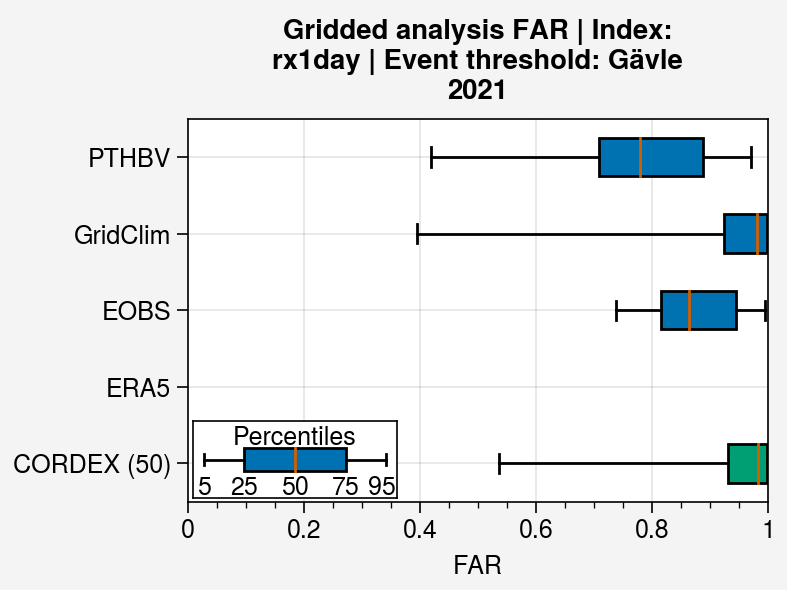

In [14]:
boxes = [
    {
        "label": label,
        "whislo": pbr[0],
        "q1": pbr[1],
        "med": pbr[2],
        "q3": pbr[3],
        "whishi": pbr[4],
        "fliers": None,
    }
    for pbr, label in zip(far_data, pbr_labels)
]
fig, ax = pplt.subplots(
    figwidth="10.cm",
    figheight="7.5cm",
)
patches = ax.bxp(boxes[::-1], vert=False, showfliers=False, patch_artist=True)
patches["boxes"][0].set_color("C2")
patches["boxes"][0].set_edgecolor("k")

axins = ax.inset_axes([0.01, 0.01, 0.35, 0.2], zoom=False)
# Dummy barplot
legend_box = {
    "label": None,
    "whislo": 5,
    "q1": 25,
    "med": 50,
    "q3": 75,
    "whishi": 95,
    "fliers": None,
}
axins.bxp(
    [
        legend_box,
    ],
    patch_artist=True,
    showfliers=False,
    vert=False,
    widths=0.3,
)
# Annotate percentiles.
axins.annotate("5", (5, 0.55), ha="center")
axins.annotate("25", (25, 0.55), ha="center")
axins.annotate("50", (50, 0.55), ha="center")
axins.annotate("75", (75, 0.55), ha="center")
axins.annotate("95", (93, 0.55), ha="center")
axins.annotate(
    "Percentiles", (0.5, 0.95), ha="center", va="top", xycoords="axes fraction"
)
axins.format(
    grid=False,
    xticklabelloc=None,
    xticklabels=[],
    xticks=False,
    yticks=False,
    xlim=(0, 100),
)

# axins.set_facecolor('none')

# Labels
title = "\n".join(wrap(f"Gridded analysis FAR | Index: {index_name} | Event threshold: {threshold_name}", 35))
ax.format(
    xlabel="FAR",
    suptitle=title,
    xreverse=False,
    xlim=(0, 1),
    ytickminor=False,
);

In [16]:
fig.save(f"../../plots/gridded_FAR_{index_name}_gavle21.pdf")